In [1]:
import time
import pandas as pd
import numpy as np
import math
import optuna
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset

## Load datasets

In [2]:
# Load datasets
# Train Data
temp_df = pd.read_csv("../data/cleaned/train_wo_weather.csv", nrows=0)  # Read only the header
total_columns = len(temp_df.columns)
columns_to_use = temp_df.columns[1:total_columns]
train_data = pd.read_csv("../data/cleaned/train_wo_weather.csv", usecols=columns_to_use)

# Test Data
test_data = pd.read_csv("../data/cleaned/test_wo_weather.csv", usecols=columns_to_use)

## Process datasets

In [ ]:
# *** Do not drop 'date' column yet ***
train_data = train_data.drop(columns=['building_name', 'site_name', 'sqft'])
test_data = test_data.drop(columns=['building_name', 'site_name', 'sqft'])

# Convert 'date' column to datetime
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

# Define the meters to filter by
selected_meters = ['chilledwater', 'hotwater', 'electricity', 'gas']

# Filter train and test data for selected meters
train_data = train_data[train_data['meter'].isin(selected_meters)]
test_data = test_data[test_data['meter'].isin(selected_meters)]



# Building index on building_id for further assessment
train_data.set_index('building_id', inplace=True)
test_data.set_index('building_id', inplace=True)

# Define features and types based on dataset
numerical_features = ['sqm']
categorical_features = ['sub_primaryspaceusage', 'site_id', 'weekday', 'month']

results = []

### Drop the columns that we may not use during training

In [ ]:
train_data.drop(columns=['primaryspaceusage', 'timezone', 'season'], inplace=True)
test_data.drop(columns=['primaryspaceusage', 'timezone', 'season'], inplace=True)

In [5]:
train_data.head()

,meter,date,meter_reading,sub_primaryspaceusage,sqm,site_id,month,weekday
building_id,,,,,,,,
1,electricity,2016-01-01,2.9050,Education,609.8,1,1,4
1,electricity,2016-01-02,2.7700,Education,609.8,1,1,5
1,electricity,2016-01-03,2.6725,Education,609.8,1,1,6
1,electricity,2016-01-04,4.5650,Education,609.8,1,1,0
1,electricity,2016-01-05,4.7825,Education,609.8,1,1,1


In [6]:
test_data.head()

,meter,date,meter_reading,sub_primaryspaceusage,sqm,site_id,month,weekday
building_id,,,,,,,,
1,electricity,2017-01-01,2.1775,Education,609.8,1,1,6
1,electricity,2017-01-02,2.7925,Education,609.8,1,1,0
1,electricity,2017-01-03,7.1100,Education,609.8,1,1,1
1,electricity,2017-01-04,6.8450,Education,609.8,1,1,2
1,electricity,2017-01-05,3.9500,Education,609.8,1,1,3


In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 553758 entries, 1 to 924
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   meter                  553758 non-null  object        
 1   date                   553758 non-null  datetime64[ns]
 2   meter_reading          553758 non-null  float64       
 3   sub_primaryspaceusage  553758 non-null  object        
 4   sqm                    553758 non-null  float64       
 5   site_id                553758 non-null  int64         
 6   month                  553758 non-null  int64         
 7   weekday                553758 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 38.0+ MB


In [8]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 552245 entries, 1 to 924
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   meter                  552245 non-null  object        
 1   date                   552245 non-null  datetime64[ns]
 2   meter_reading          552245 non-null  float64       
 3   sub_primaryspaceusage  552245 non-null  object        
 4   sqm                    552245 non-null  float64       
 5   site_id                552245 non-null  int64         
 6   month                  552245 non-null  int64         
 7   weekday                552245 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 37.9+ MB


In [10]:
unique_meters = train_data['meter'].unique()
unique_meters

array(['electricity', 'chilledwater', 'gas', 'hotwater'], dtype=object)

## Select meter value (type of meter) used for modelling

In [11]:
meter_value = 'hotwater'

## Define Evaluation metrics

In [12]:
# Define custom evaluation metrics
def root_mean_squared_error(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return math.sqrt(mse)

def coefficient_of_variation_root_mean_squared_error(y_true, y_pred):
    rmse = root_mean_squared_error(y_true, y_pred)
    return rmse / np.mean(y_true) * 100

def mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return np.mean(dif)

def normalized_mean_bias_error(y_true, y_pred):
    dif = y_true - y_pred
    return (np.sum(dif) / (len(y_true) * np.mean(y_true))) * 100

def r_squared(y_true, y_pred):
    return r2_score(y_true, y_pred)

## Data Preprocessing Functions for Model Training


In [13]:
# Function to preprocess data
def preprocess_data(X, y=None, fit_scaler=False, scaler=None, y_scaler=None):
    # Convert categorical features to 'category' type
    for cat_col in categorical_features:
        X[cat_col] = X[cat_col].astype('category')

    # Log-transform 'sqm' if it's a highly skewed feature
    if 'sqm' in X.columns:
        X['sqm'] = np.log1p(X['sqm'])

    # Scale numerical features
    if fit_scaler:
        scaler = StandardScaler()
        X[numerical_features] = scaler.fit_transform(X[numerical_features])
        
        if y is not None:
            
            # Cap y at the 99th percentile to handle outliers
            cap_value = np.percentile(y, 99)
            y = np.clip(y, None, cap_value)  # Cap extreme values
            
            # Log-transform and scale the target
            y_log = np.log1p(y)
            y_scaler = StandardScaler()
            y_scaled = y_scaler.fit_transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled, scaler, y_scaler
        else:
            return X, scaler
    else:
        X[numerical_features] = scaler.transform(X[numerical_features])
        
        if y is not None:
            # Log-transform and scale the target using the provided scaler
            y_log = np.log1p(y)
            y_scaled = y_scaler.transform(y_log.values.reshape(-1, 1)).flatten()
            return X, y_scaled
        else:
            return X

## Training Models

### Process training data (2016)

In [14]:
print(f"==============  Processing meter value: {meter_value} =====================")
# Filter data and preprocess
meter_filter = train_data['meter'] == meter_value
X_meter = train_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_meter = train_data.loc[meter_filter, 'meter_reading']

X_train_full_processed, y_train_full_scaled, scaler, y_scaler = preprocess_data(
    X_meter.copy(), y_meter, fit_scaler=True
)

for col in categorical_features:
    X_train_full_processed[col] = X_train_full_processed[col].astype('category')

==============  Processing meter value: hotwater =====================


In [15]:
X_train_full_processed.head()

,sub_primaryspaceusage,sqm,site_id,month,weekday
building_id,,,,,
68,Academic,0.584485,2,1,4
68,Academic,0.584485,2,1,5
68,Academic,0.584485,2,1,6
68,Academic,0.584485,2,1,0
68,Academic,0.584485,2,1,1


In [16]:
X_train_full_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42822 entries, 68 to 886
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sub_primaryspaceusage  42822 non-null  category
 1   sqm                    42822 non-null  float64 
 2   site_id                42822 non-null  category
 3   month                  42822 non-null  category
 4   weekday                42822 non-null  category
dtypes: category(4), float64(1)
memory usage: 837.8 KB


### Process test data (2017)

In [17]:
meter_filter = test_data['meter'] == meter_value
X_test_meter = test_data.loc[meter_filter].drop(columns=['meter_reading', 'meter', 'date'])
y_test_meter = test_data.loc[meter_filter, 'meter_reading']

X_test_processed, y_test_scaled = preprocess_data(
    X_test_meter.copy(), y_test_meter, fit_scaler=False, scaler=scaler, y_scaler=y_scaler  
)  # Must use the same scaler as the training set to prevent data leakage

# Ensure that categorical columns in X_test_processed have the same levels as in X_train_processed
for col in categorical_features:
    X_test_processed[col] = X_test_processed[col].astype('category')

In [18]:
X_test_processed.head()

,sub_primaryspaceusage,sqm,site_id,month,weekday
building_id,,,,,
68,Academic,0.584485,2,1,6
68,Academic,0.584485,2,1,0
68,Academic,0.584485,2,1,1
68,Academic,0.584485,2,1,2
68,Academic,0.584485,2,1,3


In [19]:
X_test_processed.info() 

<class 'pandas.core.frame.DataFrame'>
Index: 42705 entries, 68 to 886
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   sub_primaryspaceusage  42705 non-null  category
 1   sqm                    42705 non-null  float64 
 2   site_id                42705 non-null  category
 3   month                  42705 non-null  category
 4   weekday                42705 non-null  category
dtypes: category(4), float64(1)
memory usage: 835.5 KB


### Define Parameters

* Ideally, we would use the parameters obtained from the model optimization process described above.
* However, to save time, we’ve opted to skip the hyperparameter tuning step and instead directly define a set of parameters.

In [20]:
best_params = {
    'num_leaves': 1000,                # Reduce to limit complexity
    'learning_rate': 0.01,           # Lower learning rate
    'max_bin': 512,                   # Reduce max_bin
    'lambda_l1': 0.01,                 # Add L1 regularization
    'lambda_l2': 0.01,                 # Add L2 regularization
    'min_child_samples': 20,          # Increase min_child_samples
    'max_depth': 15,                  # Limit max_depth
}

### Define functions to train the model

In [21]:
# Custom callback to log progress with estimated remaining time
class TimeEstimatorCallback:
    def __init__(self, num_boost_round, display_interval=50):
        self.num_boost_round = num_boost_round
        self.display_interval = display_interval
        self.start_time = None

    def __call__(self, env):
        if env.iteration == 0:
            self.start_time = time.time()
        
        if env.iteration % self.display_interval == 0:
            elapsed_time = time.time() - self.start_time
            average_time_per_iter = elapsed_time / (env.iteration + 1)
            remaining_iters = self.num_boost_round - env.iteration
            estimated_remaining_time = remaining_iters * average_time_per_iter
            
            # Check if evaluation results are available
            if env.evaluation_result_list:
                rmse = env.evaluation_result_list[0][2]
                print(f"[Iteration {env.iteration}] RMSE: {rmse:.4f} "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")
            else:
                print(f"[Iteration {env.iteration}] No evaluation results "
                      f"| Elapsed: {elapsed_time:.2f}s "
                      f"| Estimated Remaining: {estimated_remaining_time:.2f}s")

# Function to train the final model with tuned parameters (no validation set)
def train_final_model(X_train, y_train, best_params):
    final_params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'device': 'cpu',
        'verbosity': -1,
    }
    final_params.update(best_params)

    # Create the LightGBM training dataset
    lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
    
    num_boost_round = 1000

    # Train the model only on the training set, without validation logging
    model = lgb.train(
        final_params,
        lgb_train,
        num_boost_round=num_boost_round,
        valid_sets=[lgb_train],  # Only use the training set here
        callbacks=[
            lgb.log_evaluation(100),            # Log training metrics every 100 rounds
            TimeEstimatorCallback(num_boost_round, 100)  # Estimate time every 50 iterations
        ]
    )

    return model

### Train the model

In [22]:
print("========== Training the final model ==========================")

final_model = train_final_model(X_train_full_processed, y_train_full_scaled, best_params)

========== Training the final model ==========================
[Iteration 0] RMSE: 0.9917 | Elapsed: 0.00s | Estimated Remaining: 0.01s
[100]	training's rmse: 0.504234
[Iteration 100] RMSE: 0.5016 | Elapsed: 0.82s | Estimated Remaining: 7.32s
[200]	training's rmse: 0.36589
[Iteration 200] RMSE: 0.3653 | Elapsed: 3.84s | Estimated Remaining: 15.28s
[300]	training's rmse: 0.329579
[Iteration 300] RMSE: 0.3294 | Elapsed: 24.40s | Estimated Remaining: 56.74s
[400]	training's rmse: 0.316685
[Iteration 400] RMSE: 0.3166 | Elapsed: 29.45s | Estimated Remaining: 44.06s
[500]	training's rmse: 0.311282
[Iteration 500] RMSE: 0.3112 | Elapsed: 305.22s | Estimated Remaining: 304.61s
[600]	training's rmse: 0.307781
[Iteration 600] RMSE: 0.3077 | Elapsed: 441.23s | Estimated Remaining: 293.67s
[700]	training's rmse: 0.305607
[Iteration 700] RMSE: 0.3056 | Elapsed: 469.19s | Estimated Remaining: 200.79s
[800]	training's rmse: 0.304031
[Iteration 800] RMSE: 0.3040 | Elapsed: 484.58s | Estimated Remaini

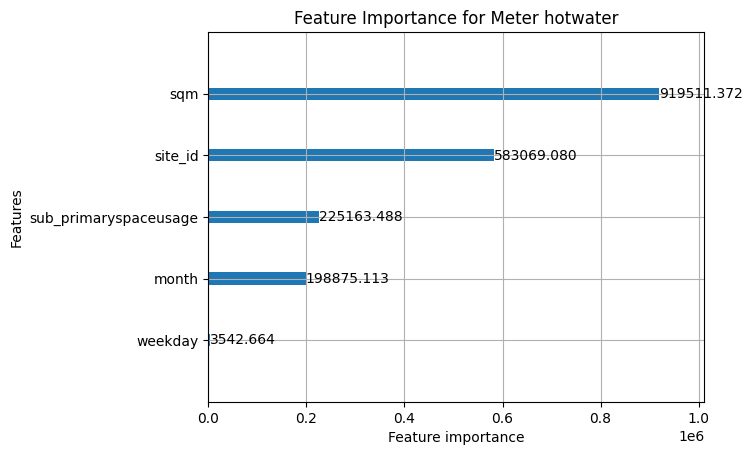

In [23]:
# Plot the feature importance
ax = lgb.plot_importance(final_model, max_num_features=20, importance_type='gain')
plt.title(f"Feature Importance for Meter {meter_value}")
plt.show()

## Check Model Performance on training dataset

### Define functions to evaluate model

In [24]:
def evaluate_model(model, X_test, y_test, y_scaler):
    # Get predictions
    y_pred_scaled = model.predict(X_test)
    y_pred_log = y_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_pred = np.expm1(y_pred_log).flatten()  # Transform back from log scale

    # Since y_test is already in original scale, no transformation needed
    y_true = y_test

    # Calculate metrics
    rmse = root_mean_squared_error(y_true, y_pred)
    cvrmse = coefficient_of_variation_root_mean_squared_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    nmbe = normalized_mean_bias_error(y_true, y_pred)
    r2 = r_squared(y_true, y_pred)

    # Create the results DataFrame including X_test features
    results_df = pd.DataFrame(X_test).copy()
    results_df['y_true'] = y_true
    results_df['y_pred'] = y_pred

    return rmse, cvrmse, nmbe, mbe, r2, results_df

### Evaluate model on training dataset

In [26]:
print("Evaluating the model on training set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe, r2, results_df_training = evaluate_model(final_model, X_train_full_processed, y_meter, y_scaler)

# append metrics to 
results_training = []
results_training.append({
    'meter_value': meter_value,
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
})

print(f"Results for meter {meter_value} on train set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")


Evaluating the model on training set
Results for meter hotwater on train set:
       RMSE=1161511.8963,
       CV-RMSE=121.6145 %,
       NMBE=15.0602 %,
       MBE=143836.4209,
       R2=0.7428


### Visualize Prediction versus Actual on training set

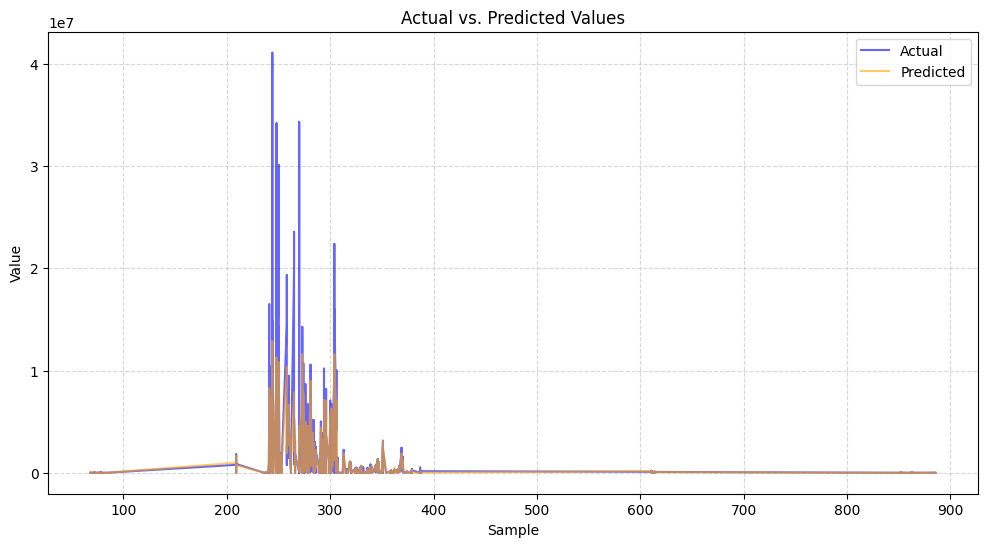

In [27]:
plt.figure(figsize=(12, 6))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df_training['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df_training['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()

## Evaluate model on test set

In [28]:
print("Evaluating the model on test set")
# Evaluate the model
rmse, cvrmse, nmbe, mbe,r2 ,results_df = evaluate_model(final_model, X_test_processed, y_test_meter, y_scaler)

# append metrics to 
results.append({
    'meter_value': meter_value,
    'best_params': best_params,
    'rmse': rmse,
    'cv-rmse': cvrmse,
    'nmbe': nmbe,
    'r2_score': r2
})

print(f"Results for meter {meter_value} on train set:\n \
      RMSE={round(rmse, 4)},\n \
      CV-RMSE={round(cvrmse, 4)} %,\n \
      NMBE={round(nmbe, 4)} %,\n \
      MBE={round(mbe, 4)},\n \
      R2={round(r2, 4)}")

Evaluating the model on test set
Results for meter hotwater on train set:
       RMSE=2104897.2871,
       CV-RMSE=220.3821 %,
       NMBE=15.1536 %,
       MBE=144733.8057,
       R2=0.3649


In [29]:
results_df.sample(10)

,sub_primaryspaceusage,sqm,site_id,month,weekday,y_true,y_pred
building_id,,,,,,,
379,Office,0.678378,7,6,4,0.000000e+00,-9.205688e-02
238,Academic,0.141318,5,7,5,5.334900e+00,7.283264e-01
292,Office,-1.061631,6,11,2,2.546216e+06,1.673628e+06
365,College Laboratory,-0.093778,7,2,5,1.262593e+05,1.096706e+05
885,Office,0.991760,15,1,0,0.000000e+00,6.067354e+03
286,Office,-1.598199,6,6,4,9.495500e+05,8.880621e+05
334,College Classroom,-0.157603,7,12,2,0.000000e+00,3.079595e+02
347,College Laboratory,-1.189720,7,12,0,9.791543e+04,4.123550e+05
371,Office,-0.518497,7,10,1,6.871226e+03,1.427602e+04


### Visualize actual versus predictions on test set

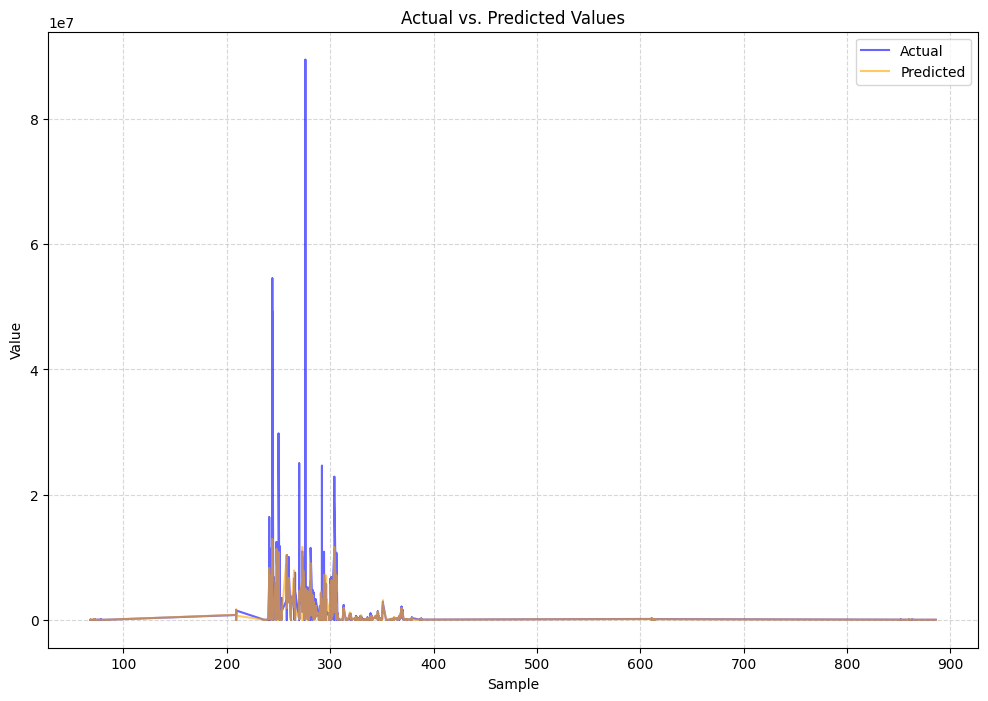

: 

In [ ]:
plt.figure(figsize=(12, 8))

# Use contrasting colors and adjust the line width for better visibility
plt.plot(results_df['y_true'], label="Actual", color="blue", alpha=0.6, linewidth=1.5)
plt.plot(results_df['y_pred'], label="Predicted", color="orange", alpha=0.6, linewidth=1.5)

plt.xlabel("Sample")
plt.ylabel("Value")
plt.legend()
plt.title("Actual vs. Predicted Values")
plt.grid(True, linestyle='--', alpha=0.5)  # Add a light grid for better readability

plt.show()